# Preview Evaluation - Perplexity

Thia is a notebook to make a preview comparison of the generations when using Perplexity as a metric for the Datamodels collections.  
Important to notice, this notebook is considering onle ONE generation of 50 samples.

In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from utils.metrics.calculate_metric import calculate_agg_metric
import os
import numpy as np
import json

/home/caio.rhoden/miniconda3/envs/nq_dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Calculate Metrics and save them

In [2]:
seeds = [7270, 860, 5191, 5734]

In [3]:
for s in seeds:
    questions_path = f"../../datamodels_training_window_size/experiments_{s}/questions.feather"
    for file in os.listdir(f"../experiments_{s}/generations"):
        print(file)
        calculate_agg_metric(
            metrics=["rouge_l"],
            generation_path=f"../experiments_{s}/generations/{file}",
            reference_path=questions_path,
            saving_path=f"result_{s}_{file.split('.')[0]}.feather"
        )




perplexity_with_instruction.json
datamodels_generations.json
rag_generations.json
baseline_7270_baseline_generations.json
perplexity_baseline.json
perplexity_with_instruction.json
datamodels_generations.json
baseline_860_baseline_generations.json
rag_generations.json
perplexity_baseline.json
baseline_5191_baseline_generations.json
perplexity_with_instruction.json
datamodels_generations.json
rag_generations.json
baseline_5734_baseline_generations.json
perplexity_with_instruction.json
datamodels_generations.json
rag_generations.json


## Load Data

In [9]:
### Perplexity results

_perplexitiy_results = []
for f in os.listdir("."):
    if f.endswith("feather"):
        processsed_namefile = f.split(".")[0].split("result_")[1]
        seed = processsed_namefile.split("_")[0]
        run_type = processsed_namefile.split("_")[1]
        if run_type == "perplexity":
            run_type += f"_{processsed_namefile.split('_')[2]}"
        _perplexitiy_results.append(pl.read_ipc(f).with_columns(pl.lit(seed).alias("seed"), pl.lit(run_type).alias("run_type")))
perplexity_results = pl.concat(_perplexitiy_results)
perplexity_results.group_by("seed", "run_type", "metric").agg(pl.col("mean").mean()).sort("seed", "run_type")

seed,run_type,metric,mean
str,str,str,f64
"""5191""","""baseline""","""rouge_l""",0.117714
"""5191""","""datamodels""","""rouge_l""",0.58269
"""5191""","""perplexity_with""","""rouge_l""",0.01641
"""5191""","""rag""","""rouge_l""",0.173952
"""5734""","""baseline""","""rouge_l""",0.149668
…,…,…,…
"""860""","""baseline""","""rouge_l""",0.165779
"""860""","""datamodels""","""rouge_l""",0.735651
"""860""","""perplexity_baseline""","""rouge_l""",0.003077


<Axes: xlabel='seed', ylabel='mean'>

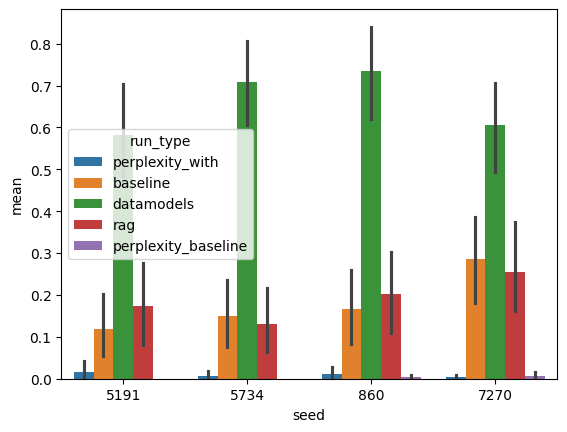

In [10]:
sns.barplot(x="seed", y="mean", hue="run_type", data=perplexity_results.filter(pl.col("metric") == "rouge_l"))

In [11]:
import json
indexes = {}
for s in seeds:
    rag_retrieval = json.load(open(f"../experiments_{s}/retrieval/rag_retrieval_indexes.json"))
    per_datamodels_retrieval = json.load(open(f"../experiments_{s}//retrieval/perplexity_with_instruction_indexes.json"))
    rou_datamodels_retrieval = json.load(open(f"../experiments_{s}//retrieval/size_2000_indexes.json"))
    dicts = [rag_retrieval, per_datamodels_retrieval, rou_datamodels_retrieval]
    processed_dicts = []
    for d in dicts:
        # Get values in order and convert to numpy arrayzz
        array_50x100 = np.array([d[str(key)] for key in range(50)])
        # Take first 16 elements
        array_50x16 = array_50x100[:, 34:50]
        # Convert back to list if needed (otherwise keep as numpy array)
        processed_dicts.append(array_50x16.tolist())
    indexes[str(s)] = processed_dicts

In [13]:


def count_matches_no_numpy(list_a, list_b):
    matches = 0
    for key in range(50):
        for i in range(16):
            if list_a[key][i] in list_b[key]:
                matches += 1
    return matches

def count_matches_no_numpy_3(list_a, list_b, list_c):
    matches = 0
    for key in range(50):
        for i in range(16):
            if list_a[key][i] in list_b[key] and list_a[key][i] in list_c[key]:
                matches += 1
    return matches


for s in seeds:
    print(f"Seed: {s}")
    print(f"Intersection between RAG and Perplexity: {count_matches_no_numpy(indexes[str(s)][0], indexes[str(s)][1])}")
    print(f"Intersection between RAG and Datamodels: {count_matches_no_numpy(indexes[str(s)][0], indexes[str(s)][2])}")
    print(f"Intersection between Perplexity and Datamodels: {count_matches_no_numpy(indexes[str(s)][1], indexes[str(s)][2])}")
    print(f"Intersection between RAG, Perplexity and Datamodels: {count_matches_no_numpy_3(indexes[str(s)][0], indexes[str(s)][1], indexes[str(s)][2])}")

Seed: 7270
Intersection between RAG and Perplexity: 153
Intersection between RAG and Datamodels: 131
Intersection between Perplexity and Datamodels: 118
Intersection between RAG, Perplexity and Datamodels: 20
Seed: 860
Intersection between RAG and Perplexity: 118
Intersection between RAG and Datamodels: 136
Intersection between Perplexity and Datamodels: 141
Intersection between RAG, Perplexity and Datamodels: 24
Seed: 5191
Intersection between RAG and Perplexity: 133
Intersection between RAG and Datamodels: 138
Intersection between Perplexity and Datamodels: 121
Intersection between RAG, Perplexity and Datamodels: 27
Seed: 5734
Intersection between RAG and Perplexity: 137
Intersection between RAG and Datamodels: 127
Intersection between Perplexity and Datamodels: 139
Intersection between RAG, Perplexity and Datamodels: 20
